### K-Rater: Unveiling Korean Drama Ratings through Review Analysis

K-Rater is a machine learning model that predicts user scores for Korean dramas based on their written reviews. Using the power of natural language processing and sentiment analysis, the project seeks to delve into the word of cinematic experience and arising emotions translated into numerical ratings.

In [1]:
# Import all the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtext
from torchtext.data import *
import torch.nn as nn
from tqdm import tqdm

In [2]:
# Look at the data
data = pd.read_csv('reviews.csv')
data.head(3)

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121


In [3]:
# Extract the necessary columns
model_data = data[['overall_score', 'review_text']]
model_data.head(3)

,overall_score,review_text
0,9.0,the Best Song from my Crush This will now ran...
1,6.5,I'm Happy and Merry That it Ended Quickly The ...
2,4.0,This PART 2 Should Never Have Happened If you...


In [5]:
# Clean the data from empty cells
cleaned = model_data.dropna()

Text(0.5, 1.0, 'Score Distribution')

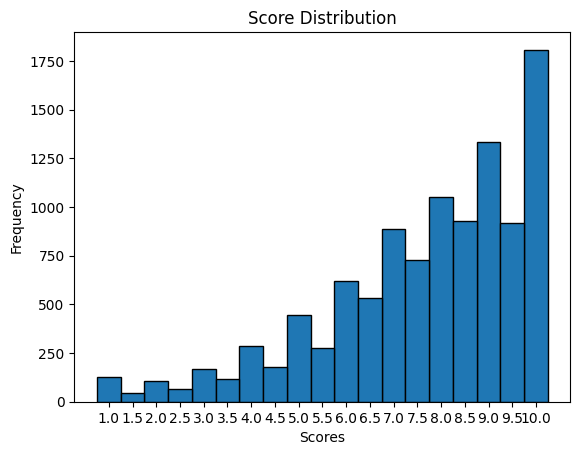

In [6]:
# Check the score distribution
score_counts = cleaned['overall_score'].value_counts()
plt.bar(score_counts.index, score_counts.values, width=0.5, align='center', edgecolor='black')
xticks_values = np.arange(1, 10.5, 0.5)
plt.xticks(xticks_values)
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Score Distribution')

/tmp/ipykernel_3033012/1528603231.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['overall_score'] = cleaned['overall_score'].apply(map_score)


Text(0.5, 1.0, 'Score Distribution')

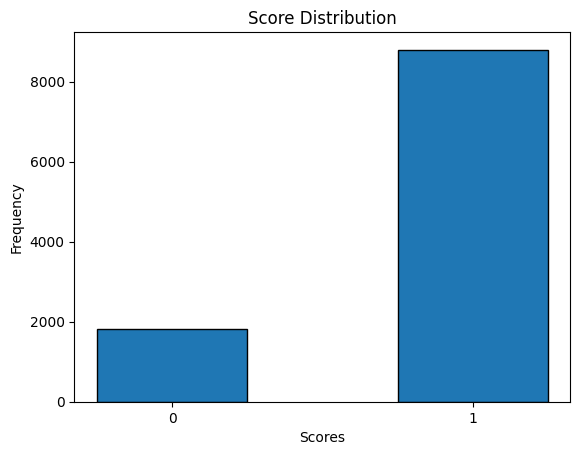

In [8]:
# Merge the scores into two classes and check the score distribution
def map_score(score):
    if 1 <= score <= 5.5:
        return 0
    elif 6 <= score <= 10:
        return 1

cleaned['overall_score'] = cleaned['overall_score'].apply(map_score)
plt.bar(cleaned['overall_score'].value_counts().index, cleaned['overall_score'].value_counts().values, width=0.5, align='center', edgecolor='black')
xticks_values = np.arange(0, 2, 1)
plt.xticks(xticks_values)
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Score Distribution')

Text(0.5, 1.0, 'Score Distribution')

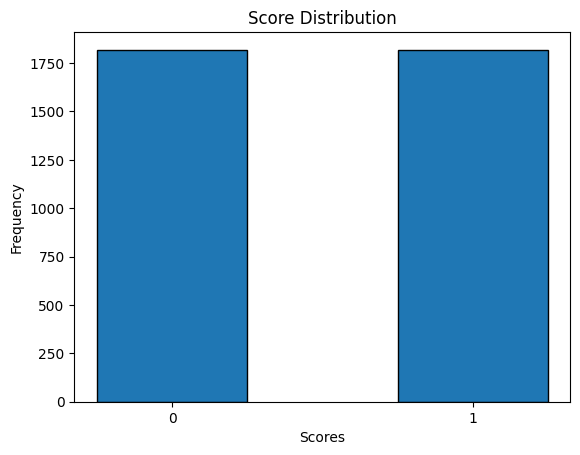

In [9]:
# Undersample the majority class
indices_to_delete = cleaned[cleaned['overall_score'] == 1].sample(n=6981, random_state=42).index
cleaned = cleaned.drop(indices_to_delete)
plt.bar(cleaned['overall_score'].value_counts().index, cleaned['overall_score'].value_counts().values, width=0.5, align='center', edgecolor='black')
xticks_values = np.arange(0, 2, 1)
plt.xticks(xticks_values)
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Score Distribution')

In [29]:
# Split the data into train, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(cleaned['review_text'], cleaned['overall_score'], test_size=0.3, stratify=cleaned['overall_score'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [30]:
# Save the new data to csv files
train = pd.DataFrame(list(zip(X_train, y_train)),
               columns =['review', 'score'])
train.to_csv('train3.csv', index=False)
validation = pd.DataFrame(list(zip(X_val, y_val)),
               columns =['review', 'score'])
validation.to_csv('validation3.csv', index=False)
test = pd.DataFrame(list(zip(X_test, y_test)),
               columns =['review', 'score'])
test.to_csv('test3.csv', index=False)

In [32]:
# Create a dataloader
def dataloader(path, batch_size, device):
    review = torchtext.data.Field(tokenize=lambda x: x.split(), lower=True, stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "can", "will", "just", "should", "now"])
    score = torchtext.data.Field(sequential=False, unk_token=None)
    train_dataset, val_dataset, test_dataset = torchtext.data.TabularDataset.splits(path=path,
                                                                       train='train3.csv',
                                                                       validation='validation3.csv',
                                                                       test='test3.csv',
                                                                       format='csv',
                                    fields=[('review', review), ('score', score)],
                                                                      skip_header=True)
    train_iterator = BucketIterator(train_dataset, batch_size=batch_size, device=device, shuffle=True)
    val_iterator = BucketIterator(val_dataset, batch_size=batch_size, device=device, shuffle=True)
    test_iterator = BucketIterator(test_dataset, batch_size=batch_size, device=device, shuffle=True)
    review.build_vocab(train_dataset, val_dataset, test_dataset)
    score.build_vocab(train_dataset, val_dataset, test_dataset)
    return review.vocab, score.vocab, train_iterator, val_iterator, test_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = "./"
batch_size = 8
review_vocab, score_vocab, train_iterator, val_iterator, test_iterator = dataloader(path, batch_size, device)

In [50]:
# batch.review = [number of words, number of reviews]

In [33]:
# Define the model
class BiLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, output_dim):
        super(BiLSTM, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_size * 2, output_dim)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, review):
        texts = review.permute(1, 0)
        reviews_embeddings = self.embeddings(texts)
        processed, (_, _) = self.rnn(reviews_embeddings)
        drop_out = self.dropout(processed)
        predictions = self.classifier(drop_out)
        return predictions

In [36]:
# Train the model
loss_function = nn.CrossEntropyLoss().to(device)
model = BiLSTM(len(review_vocab), 256, 512, len(score_vocab))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    progress_bar = tqdm(total=len(train_iterator), desc=f'Training epoch {epoch+1}/{epochs}', unit='batch')
    
    for batch in train_iterator:
        review = batch.review
        score = batch.score
        
        predictions = model(review)
        predictions = predictions[:, -1, :]

        batch_loss = loss_function(predictions, score)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        total_correct += torch.sum(torch.argmax(predictions, dim=1) == score).item()
        total_samples += score.size(0)
        
        batch_acc = total_correct / total_samples
        progress_bar.set_postfix(loss=batch_loss.item(), acc=batch_acc)
        progress_bar.update(1)
        
    progress_bar.close()

    model.eval()
    val_loss = 0
    val_total_correct = 0
    val_total_samples = 0
    all_predictions = []
    all_scores = []
    
    with torch.no_grad():
        progress_bar = tqdm(total=len(val_iterator), desc=f'Validation epoch {epoch+1}/{epochs}', unit='batch')
        for val_batch in val_iterator:
            val_review = val_batch.review
            val_score = val_batch.score

            val_predictions = model(val_review)
            val_predictions = val_predictions[:, -1, :]

            val_batch_loss = loss_function(val_predictions, val_score)
            val_loss += val_batch_loss.item()
            val_total_correct += torch.sum(torch.argmax(val_predictions, dim=1) == val_score).item()
            val_total_samples += val_score.size(0)
            val_batch_acc = val_total_correct / val_total_samples

            all_predictions.extend(torch.argmax(val_predictions, dim=1).tolist())
            all_scores.extend(val_score.tolist())

            progress_bar.set_postfix(loss=val_batch_loss.item(), acc=val_batch_acc)
            progress_bar.update(1)
    
    progress_bar.close()

    val_loss /= val_total_samples
    val_acc = val_total_correct / val_total_samples
    
    f1_micro = f1_score(all_scores, all_predictions, average='micro')
    f1_macro = f1_score(all_scores, all_predictions, average='macro')
    precision = precision_score(all_scores, all_predictions, average='weighted')
    recall = recall_score(all_scores, all_predictions, average='weighted')
    mae = mean_absolute_error(all_scores, all_predictions)
    
    table = { 'Metrics': ['Loss', 'Accuracy', 'Micro F1', 'Macro F1', 'Precision', 'Recall', 'MAE'], 'Values': [val_loss, val_acc, f1_micro, f1_macro, precision, recall, mae]}
    df = pd.DataFrame(table)
    display(df)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered')
        break

Validation epoch 1/50: 100%|██████████| 69/69 [00:01<00:00, 54.33batch/s, acc=0.495, loss=0.737]


,Metrics,Values
0,Loss,0.089958
1,Accuracy,0.494505
2,Micro F1,0.494505
3,Macro F1,0.340268
4,Precision,0.415270
5,Recall,0.494505
6,MAE,0.505495


Validation epoch 2/50: 100%|██████████| 69/69 [00:01<00:00, 54.96batch/s, acc=0.507, loss=0.686]


,Metrics,Values
0,Loss,0.089710
1,Accuracy,0.507326
2,Micro F1,0.507326
3,Macro F1,0.375310
4,Precision,0.547363
5,Recall,0.507326
6,MAE,0.492674


Validation epoch 3/50: 100%|██████████| 69/69 [00:01<00:00, 54.19batch/s, acc=0.515, loss=0.624]


,Metrics,Values
0,Loss,0.090813
1,Accuracy,0.514652
2,Micro F1,0.514652
3,Macro F1,0.389769
4,Precision,0.580769
5,Recall,0.514652
6,MAE,0.485348


Validation epoch 4/50: 100%|██████████| 69/69 [00:01<00:00, 54.03batch/s, acc=0.513, loss=0.771]


,Metrics,Values
0,Loss,0.091173
1,Accuracy,0.512821
2,Micro F1,0.512821
3,Macro F1,0.380952
4,Precision,0.586667
5,Recall,0.512821
6,MAE,0.487179


Validation epoch 5/50: 100%|██████████| 69/69 [00:01<00:00, 55.72batch/s, acc=0.516, loss=0.651]


,Metrics,Values
0,Loss,0.089736
1,Accuracy,0.516484
2,Micro F1,0.516484
3,Macro F1,0.516458
4,Precision,0.516487
5,Recall,0.516484
6,MAE,0.483516


Validation epoch 6/50: 100%|██████████| 69/69 [00:01<00:00, 52.29batch/s, acc=0.504, loss=0.806]


,Metrics,Values
0,Loss,0.094527
1,Accuracy,0.503663
2,Micro F1,0.503663
3,Macro F1,0.500268
4,Precision,0.503765
5,Recall,0.503663
6,MAE,0.496337


Validation epoch 7/50: 100%|██████████| 69/69 [00:01<00:00, 53.98batch/s, acc=0.549, loss=0.565]


,Metrics,Values
0,Loss,0.091635
1,Accuracy,0.549451
2,Micro F1,0.549451
3,Macro F1,0.517744
4,Precision,0.567096
5,Recall,0.549451
6,MAE,0.450549


Validation epoch 8/50: 100%|██████████| 69/69 [00:01<00:00, 55.33batch/s, acc=0.555, loss=0.887]


,Metrics,Values
0,Loss,0.093339
1,Accuracy,0.554945
2,Micro F1,0.554945
3,Macro F1,0.553506
4,Precision,0.555663
5,Recall,0.554945
6,MAE,0.445055


Validation epoch 9/50: 100%|██████████| 69/69 [00:01<00:00, 52.01batch/s, acc=0.571, loss=0.733]


,Metrics,Values
0,Loss,0.092335
1,Accuracy,0.571429
2,Micro F1,0.571429
3,Macro F1,0.568365
4,Precision,0.573516
5,Recall,0.571429
6,MAE,0.428571


Validation epoch 10/50: 100%|██████████| 69/69 [00:01<00:00, 54.94batch/s, acc=0.586, loss=1.22] 


,Metrics,Values
0,Loss,0.110552
1,Accuracy,0.586081
2,Micro F1,0.586081
3,Macro F1,0.579943
4,Precision,0.591424
5,Recall,0.586081
6,MAE,0.413919


Validation epoch 11/50: 100%|██████████| 69/69 [00:01<00:00, 54.45batch/s, acc=0.579, loss=0.548]


,Metrics,Values
0,Loss,0.109694
1,Accuracy,0.578755
2,Micro F1,0.578755
3,Macro F1,0.576001
4,Precision,0.580855
5,Recall,0.578755
6,MAE,0.421245


Validation epoch 12/50: 100%|██████████| 69/69 [00:01<00:00, 53.75batch/s, acc=0.588, loss=0.797] 


,Metrics,Values
0,Loss,0.120979
1,Accuracy,0.587912
2,Micro F1,0.587912
3,Macro F1,0.587678
4,Precision,0.588112
5,Recall,0.587912
6,MAE,0.412088


Early stopping triggered


In [37]:
# Test the model
model.eval()
total_correct=0
total_samples=0

all_predictions = []
all_scores = []

for batch in test_iterator:
    review = batch.review
    score = batch.score
        
    predictions = model(review)
    predictions = predictions[:, -1, :]
   
    total_correct += torch.sum(torch.argmax(predictions, dim=1) == score).item()
    total_samples += score.size(0)
    
    all_predictions.extend(torch.argmax(predictions, dim=1).tolist())
    all_scores.extend(score.tolist())

test_acc = total_correct / total_samples
f1_micro = f1_score(all_scores, all_predictions, average='micro')
f1_macro = f1_score(all_scores, all_predictions, average='macro')
precision = precision_score(all_scores, all_predictions, average='weighted')
recall = recall_score(all_scores, all_predictions, average='weighted')
mae = mean_absolute_error(all_scores, all_predictions)

table = { 'Metrics': ['Accuracy', 'Micro F1', 'Macro F1', 'Precision', 'Recall', 'MAE'], 'Values': [test_acc, f1_micro, f1_macro, precision, recall, mae]}
df = pd.DataFrame(table)
display(df)

,Metrics,Values
0,Accuracy,0.578755
1,Micro F1,0.578755
2,Macro F1,0.576915
3,Precision,0.580148
4,Recall,0.578755
5,MAE,0.421245
